In [19]:
import os, sys
import numpy as np
from PIL import Image
from pathlib import Path
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import tifffile
import warnings
import torch

warnings.filterwarnings("ignore")
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.data.preprocessing import get_random_crops, run_pipeline
from src.models.sam3_model import SAM3Predictor
from src.utils.visualization import show_crop_sets, show_sam3_predictions
from src.utils.image import evaluate_predictions

torch.set_default_device('cpu')
_ = load_dotenv()

## 1. Visualize our dataset and crops

In [20]:
PATH_TO_DATA = Path("../data/raw/evaluate_sam3/train")
PATH_TO_EXAMPLE_DATA = Path("../data/examples/evaluate_sam3/original")

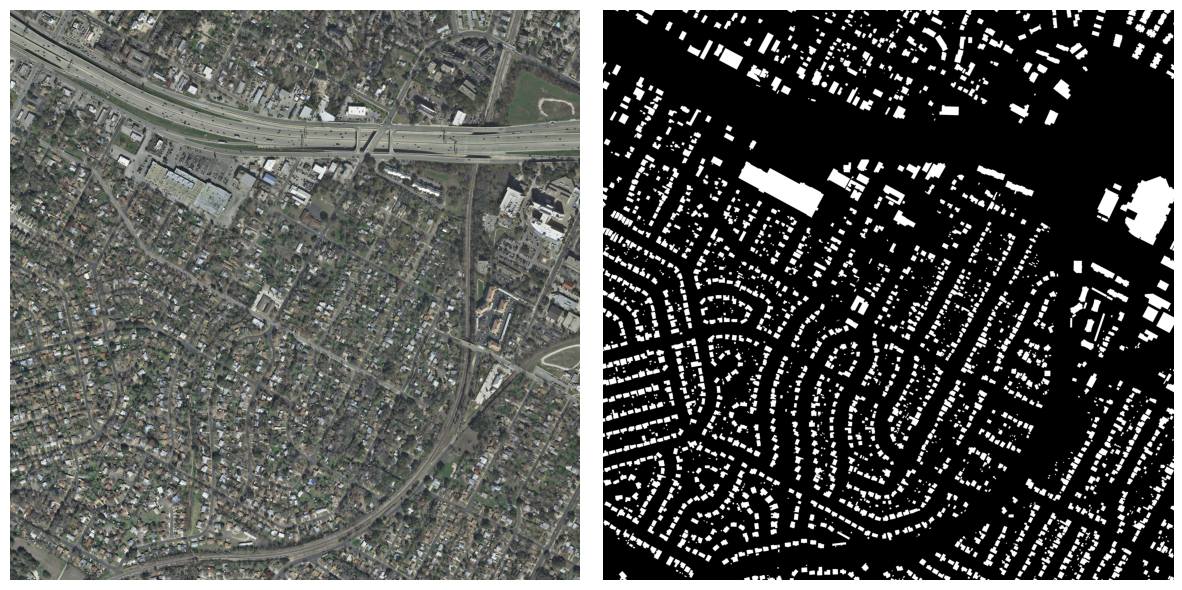

In [21]:
images_dir = PATH_TO_EXAMPLE_DATA / 'images'
img = Image.open(list(images_dir.iterdir())[0])
labels_dir = PATH_TO_EXAMPLE_DATA / 'labels'
lab = Image.open(list(labels_dir.iterdir())[0])

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(img)
axs[0].axis('off')
axs[1].imshow(lab, cmap='gray')
axs[1].axis('off')
plt.tight_layout()
plt.show()

Great! Just one thing: images from the INRIA dataset are `5000x5000` while those we use to crop patches from are `1500x1500`. We resize them to fix that.

In [22]:
train_crops, label_crops = get_random_crops(
    PATH_TO_EXAMPLE_DATA,
    train_subdir="images",
    labels_subdir="labels",
    patch_size=256,
    num_crops=16,
    new_size=(1500, 1500),
)

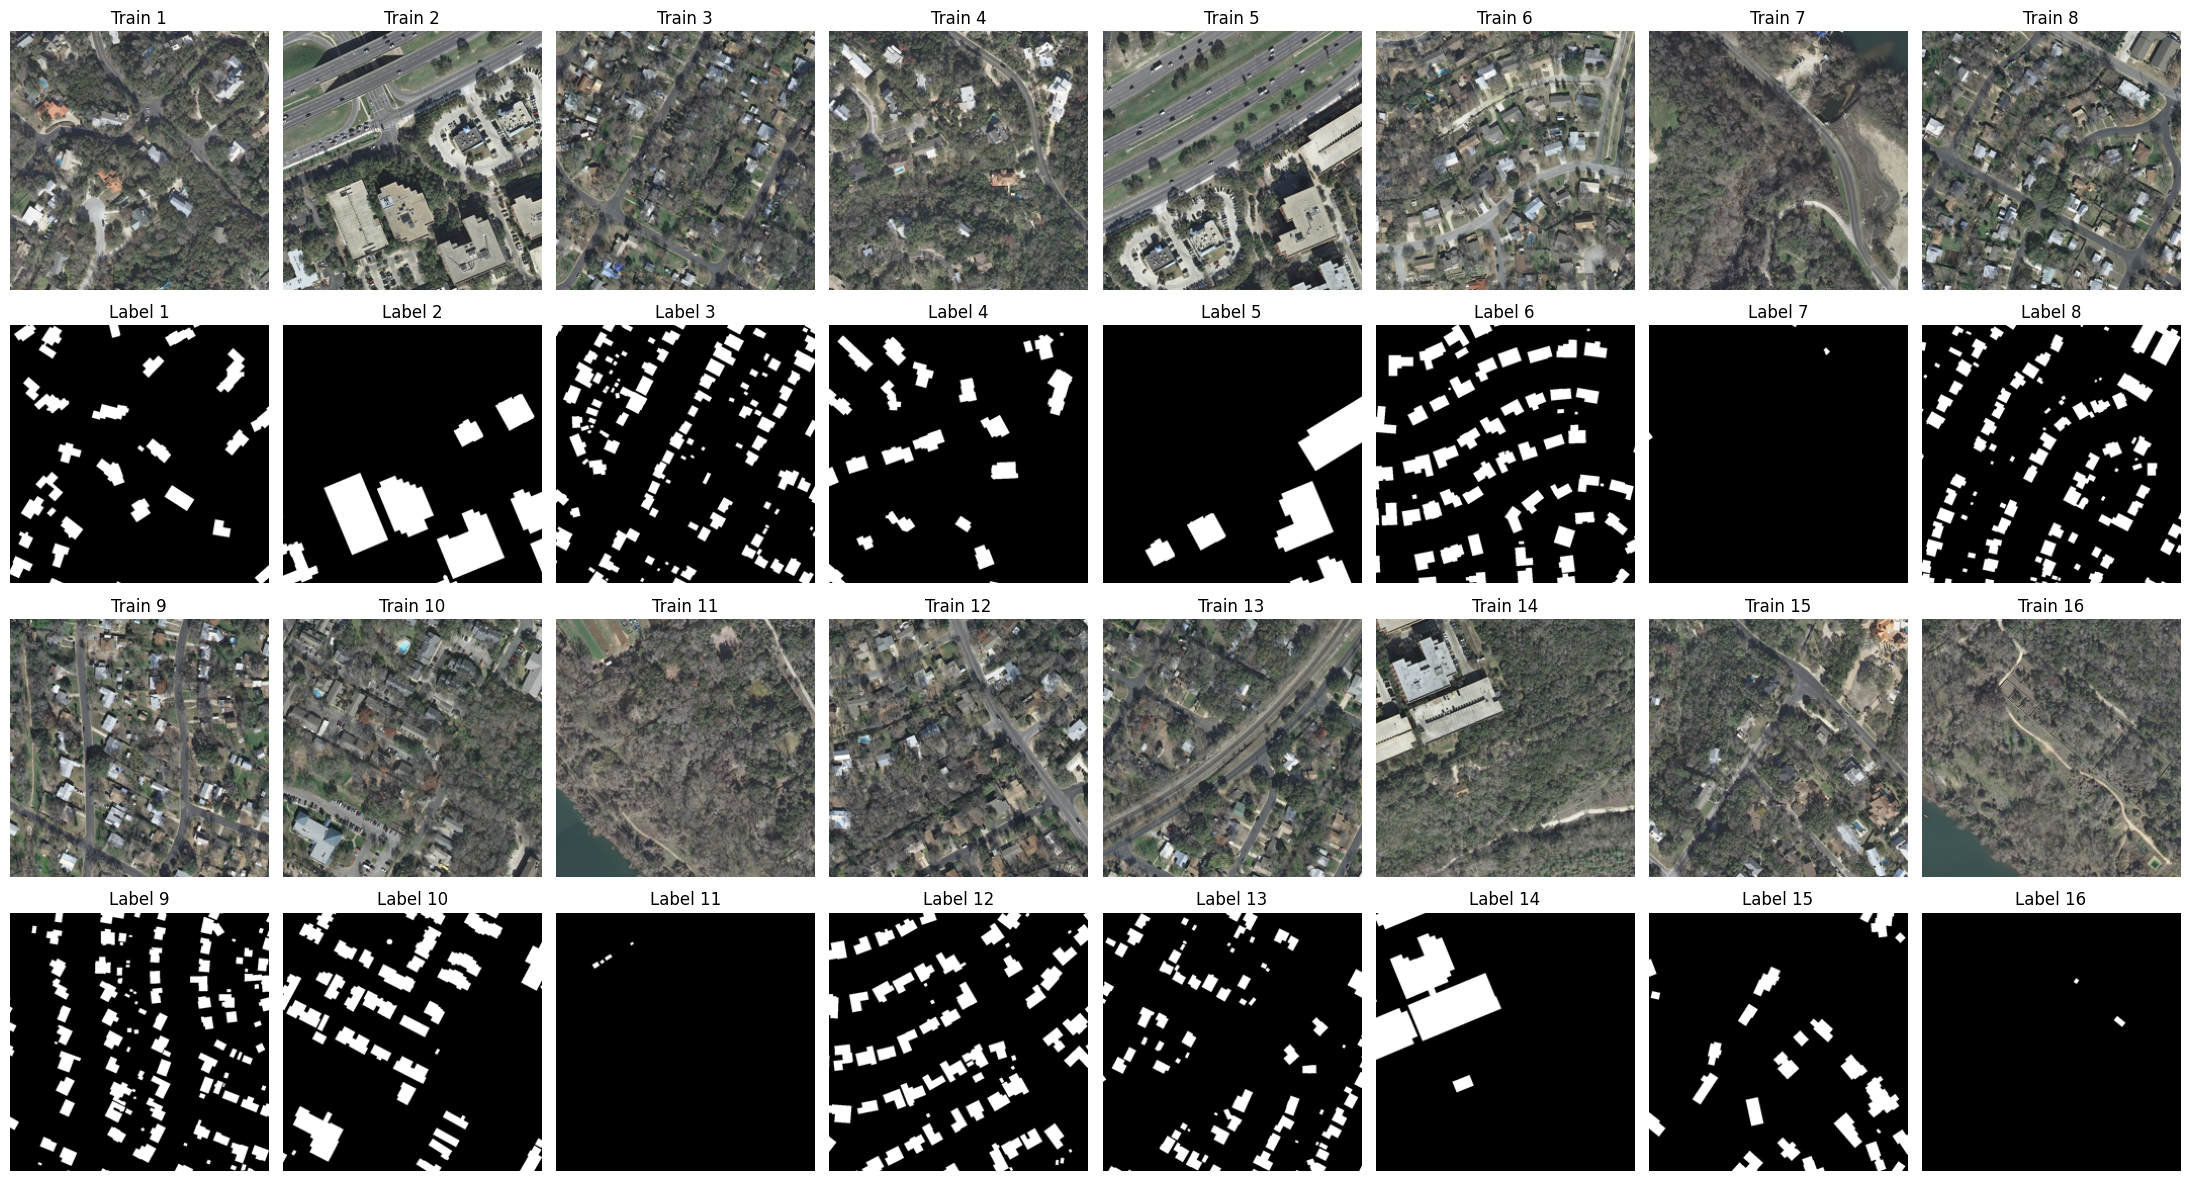

In [23]:
show_crop_sets(train_crops, label_crops)

In [7]:
_ = run_pipeline(
    input_dir="../data/examples/evaluate_sam3/original/",
    output_dir="../data/examples/evaluate_sam3/patches_256/",
    filtered_dir="../data/examples/evaluate_sam3/filtered_patches_256/",
    train_subdir="images",
    labels_subdir="labels",
    patch_size=256,
    overlap=True,
    train_max_threshold=5.0,
    label_min_threshold=2.0,
)

Extracting patches from dataset...
Filtering blank patches...
Kept: 79.13% of patches.


# Use SAM3 on patched data

In [24]:
PATH_TO_DIRECTORY= Path("../data/examples/evaluate_sam3")
PATH_TO_DATA_PATCHES = PATH_TO_DIRECTORY / "patches"
PATH_TO_DATA_PREDICTIONS = PATH_TO_DIRECTORY / "sam3_predictions"

In [25]:
predictor = SAM3Predictor()

In [35]:
image = Image.open(PATH_TO_DIRECTORY / "filtered_patches_256" / "images" / "austin1_patch_008_x1024_y0.png")
true_label = Image.open(PATH_TO_DIRECTORY / "filtered_patches_256" / "labels" / "austin1_patch_008_x1024_y0.png")

masks = predictor.predict_and_merge(image, 'building')

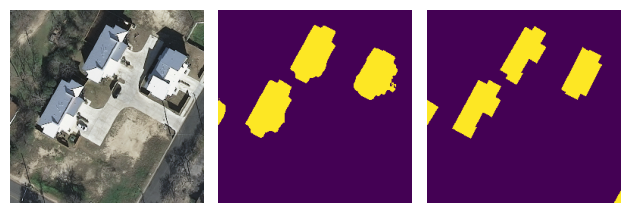

In [36]:
fig, axs = plt.subplots(1, 3)

axs[0].imshow(image)
axs[0].axis('off')
axs[1].imshow(masks)
axs[1].axis('off')
axs[2].imshow(true_label)
axs[2].axis('off')
plt.tight_layout()
plt.show()

### Predict with SAM3 for all images in patches

In [18]:
predictor.predict_and_process_directory(
    directory_path=PATH_TO_DATA_PATCHES,
    train_subdir='images',
    label_subdir='labels',
    prompt='building'
)

Processing patches: 100%|██████████| 4/4 [00:15<00:00,  3.96s/patch]

All set processed!


# Evaluate Sam3

In [17]:
path_to_aerial_data = Path("../data/raw/AerialImageDataset/train")

train_crops, label_crops = get_random_crops(
    path_to_aerial_data,
    train_subdir="images",
    labels_subdir="gt",
    patch_size=256,
    num_crops=100,
    new_size=(1500, 1500),
)

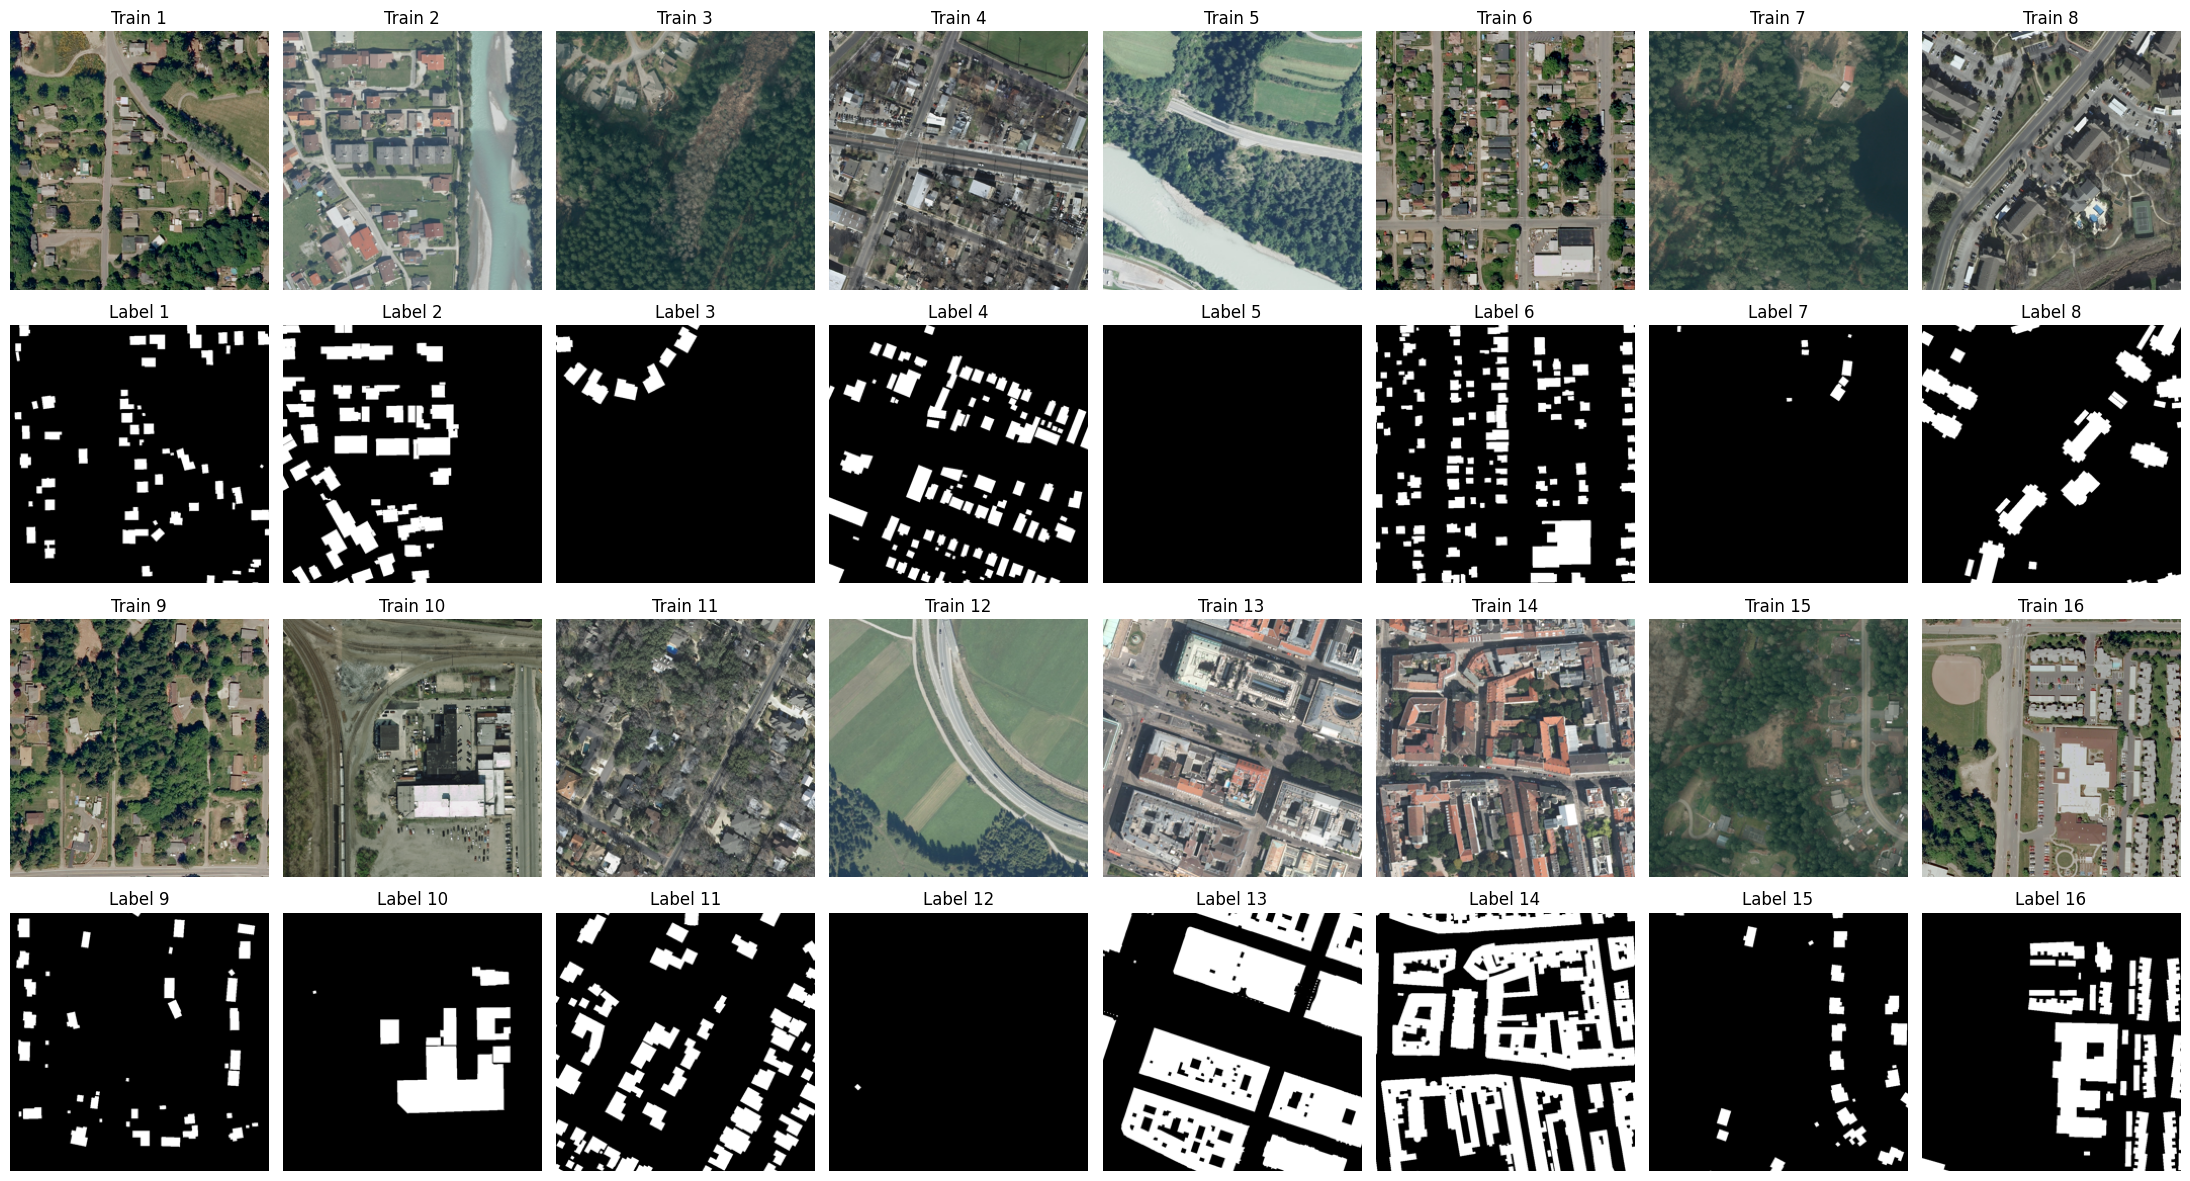

In [18]:
show_crop_sets(train_crops, label_crops)

In [15]:
base_labels_dir = Path(f'{PATH_TO_DATA_PATCHES}/labels')
sam3_labels_dir = PATH_TO_DATA_PREDICTIONS
stems = [img_path.rstrip('.png') for img_path in os.listdir(base_labels_dir)]

img2label = {base_labels_dir / (stem + '.png'): sam3_labels_dir / (stem + '_processed.tiff') for stem in stems}

In [16]:
true_paths, pred_paths = zip(*tuple(img2label.items())[:16])

true_imgs = [Image.open(path)for path in true_paths]
pred_imgs = [tifffile.imread(path)for path in pred_paths]

In [17]:
true_paths, pred_paths = zip(*tuple(img2label.items())[:16])

# Vérifier les tailles
for true_path, pred_path in list(zip(true_paths, pred_paths))[:5]:  # Afficher les 5 premiers
    train_size = Image.open(true_path).size
    label_size = tifffile.imread(pred_path).shape
    print(f"Train: {train_size} | Label: {label_size} | Match: {train_size == label_size[::-1]}")
    print(f"  {true_path.name}")
    print(f"  {pred_path.name}\n")

train_imgs = [Image.open(path) for path in true_paths]
label_imgs = [tifffile.imread(path) for path in pred_paths]

Train: (256, 256) | Label: (256, 256, 2) | Match: False
  austin1_patch_021_x2688_y0.png
  austin1_patch_021_x2688_y0_processed.tiff

Train: (256, 256) | Label: (256, 256, 2) | Match: False
  austin1_patch_033_x4224_y0.png
  austin1_patch_033_x4224_y0_processed.tiff

Train: (256, 256) | Label: (256, 256, 2) | Match: False
  austin1_patch_042_x512_y128.png
  austin1_patch_042_x512_y128_processed.tiff

Train: (256, 256) | Label: (256, 256, 2) | Match: False
  austin1_patch_054_x2048_y128.png
  austin1_patch_054_x2048_y128_processed.tiff



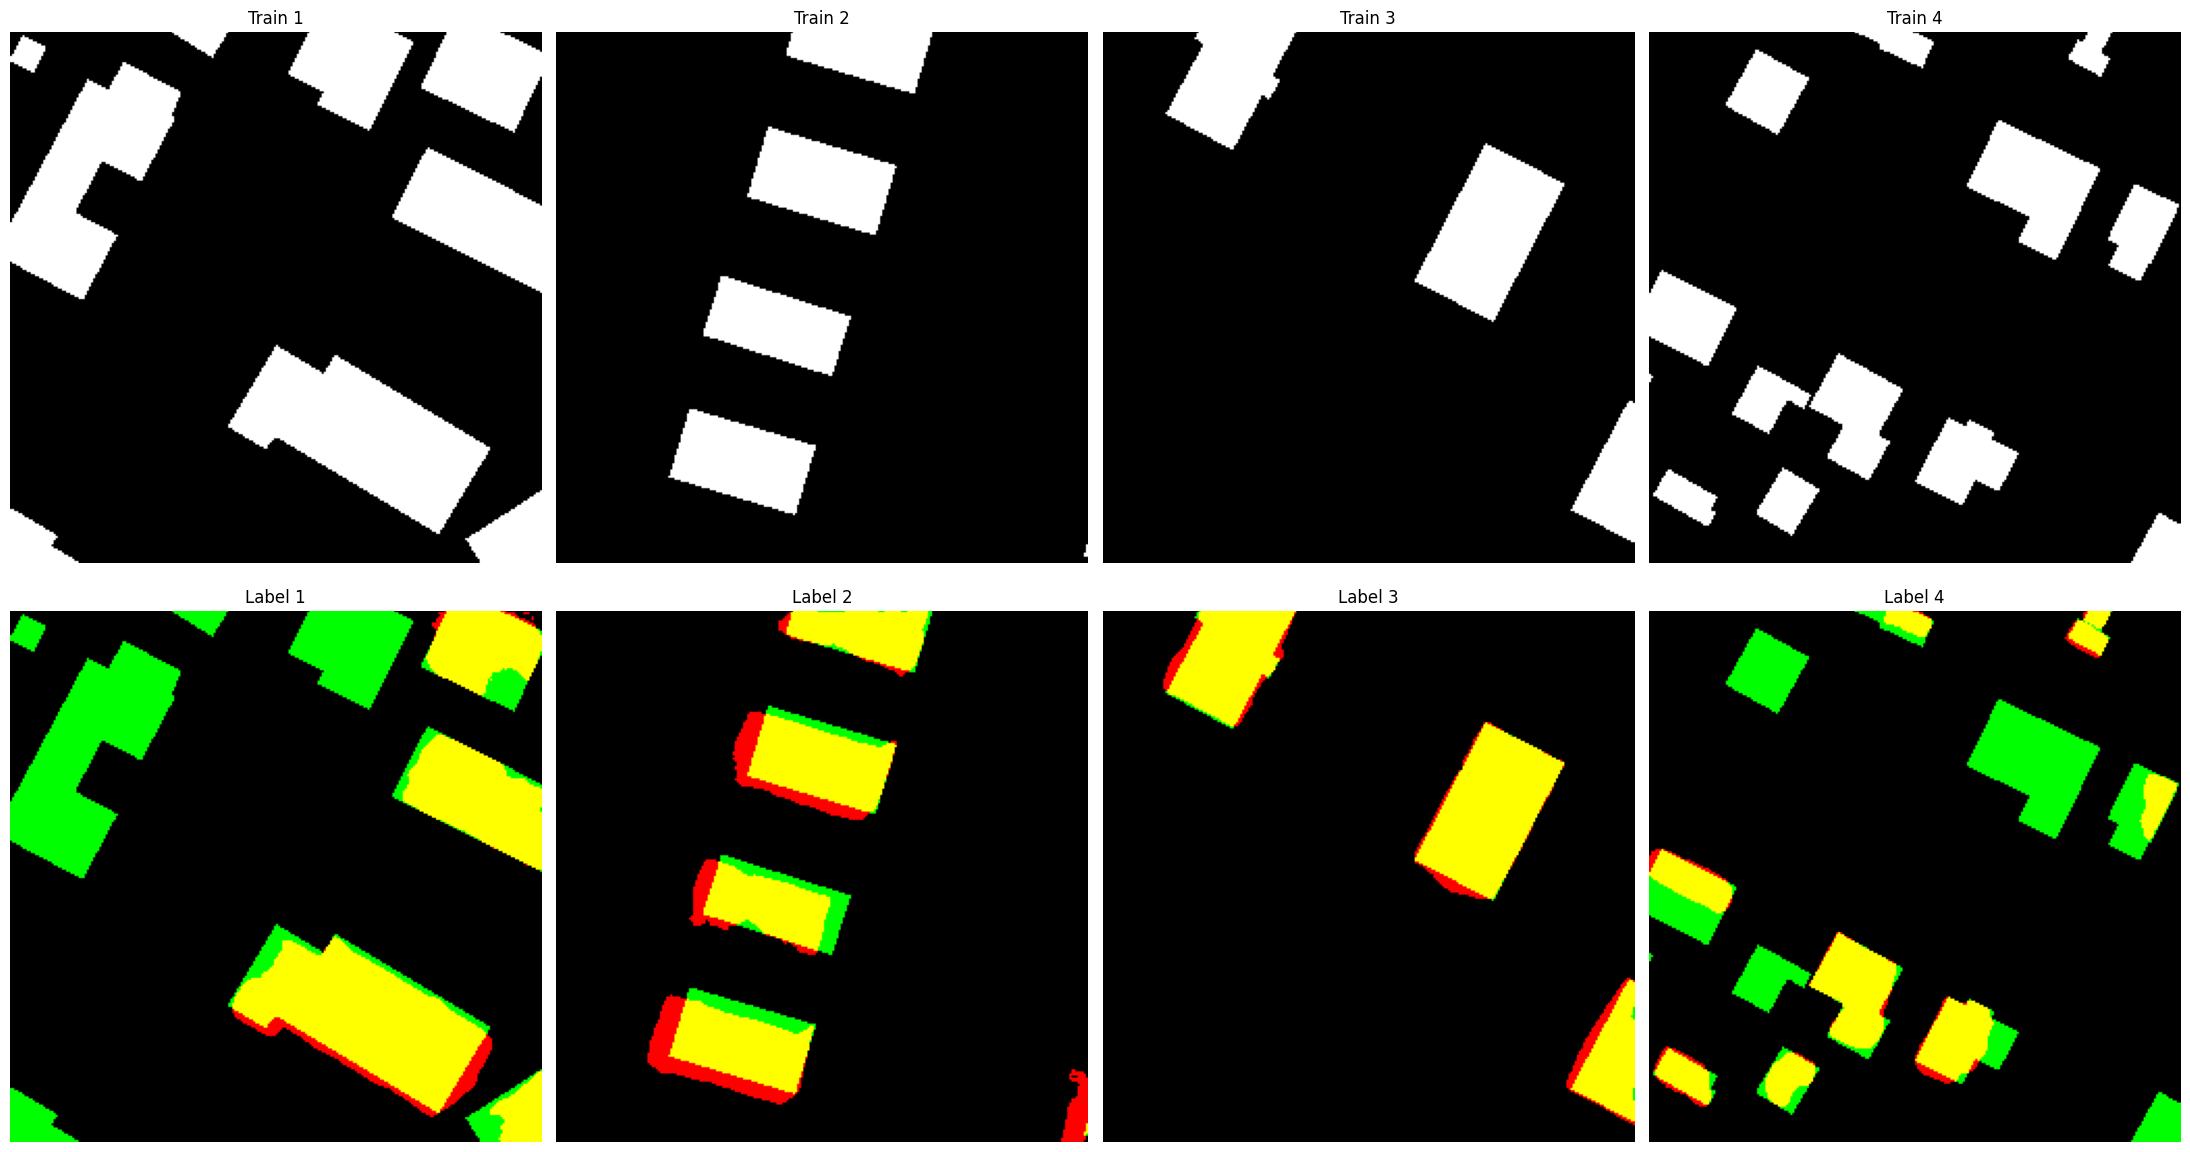

In [19]:
show_sam3_predictions(true_imgs, pred_imgs, images_per_row=4, num_sets=1)

### Display average stats

In [20]:
results = evaluate_predictions(img2label, threshold=0.5)
for metric, value in results['average'].items():
    std_value = results['std'][f'{metric}_std']
    print(f"{metric:15s}: {value:.4f} ± {std_value:.4f}")


IoU            : 0.9044 ± 0.0716
Dice           : 0.9483 ± 0.0407
Precision      : 0.9044 ± 0.0716
Recall         : 1.0000 ± 0.0000
F1-Score       : 0.9483 ± 0.0407
Accuracy       : 0.9852 ± 0.0102
Specificity    : 0.9826 ± 0.0113


### Display all stats

In [21]:
results = evaluate_predictions(img2label, threshold=0.5,isAverage=False)

if results:
    # Afficher chaque image individuellement
    for i, res in enumerate(results, 1):
        print(f"\n{'='*60}")
        print(f"Image {i}: {res['true_path']}")
        print(f"{'='*60}")
        print(f"  IoU         : {res['IoU']:.4f}")
        print(f"  Dice        : {res['Dice']:.4f}")
        print(f"  Precision   : {res['Precision']:.4f}")
        print(f"  Recall      : {res['Recall']:.4f}")
        print(f"  F1-Score    : {res['F1-Score']:.4f}")
        print(f"  Accuracy    : {res['Accuracy']:.4f}")
        print(f"  Specificity : {res['Specificity']:.4f}")
        print(f"  TP/TN/FP/FN : {res['TP']}/{res['TN']}/{res['FP']}/{res['FN']}")
    
else:
    print("No results")


Image 1: austin1_patch_021_x2688_y0.png
  IoU         : 0.9639
  Dice        : 0.9816
  Precision   : 0.9639
  Recall      : 1.0000
  F1-Score    : 0.9816
  Accuracy    : 0.9898
  Specificity : 0.9860
  TP/TN/FP/FN : 17804/47066/666/0

Image 2: austin1_patch_033_x4224_y0.png
  IoU         : 0.7895
  Dice        : 0.8823
  Precision   : 0.7895
  Recall      : 1.0000
  F1-Score    : 0.8823
  Accuracy    : 0.9679
  Specificity : 0.9636
  TP/TN/FP/FN : 7878/55557/2101/0

Image 3: austin1_patch_042_x512_y128.png
  IoU         : 0.8987
  Dice        : 0.9467
  Precision   : 0.8987
  Recall      : 1.0000
  F1-Score    : 0.9467
  Accuracy    : 0.9889
  Specificity : 0.9877
  TP/TN/FP/FN : 6434/58377/725/0

Image 4: austin1_patch_054_x2048_y128.png
  IoU         : 0.9655
  Dice        : 0.9825
  Precision   : 0.9655
  Recall      : 1.0000
  F1-Score    : 0.9825
  Accuracy    : 0.9943
  Specificity : 0.9932
  TP/TN/FP/FN : 10497/54664/375/0
